# Импортирование библиотек

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Подготовка данных

Зададим важные значения в виде переменных

In [15]:
RESIZE_TO = 256
CROP_TO = 224
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 2  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

Создадим датасет из созданного мной [набора картинок](https://colab.research.google.com/drive/1yK5eZ2GW7-Wf1EqBE1guC9I23BJETPhK?usp=sharing)

In [16]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)
traingen = datagen.flow_from_directory(
    '/content/drive/MyDrive/REM/REM_Data',
    target_size=(RESIZE_TO, RESIZE_TO),
    class_mode='binary')

Found 200 images belonging to 2 classes.


В создании генератора были использованныhorizontal_flip и vertical_flip, дянные действия создают перевернутые копии картинок. Это позволит нам увеличить количество данных и при этом сохранив основные закономерности форм капилляров, выявлением которых должна заниматься нейросеть

In [17]:
Train_ds = tf.data.Dataset.from_generator(lambda: traingen,
                                           output_types = (tf.float32, tf.float32))

# Визуализация данных

Посмотрим на некоторые из изображений датасета

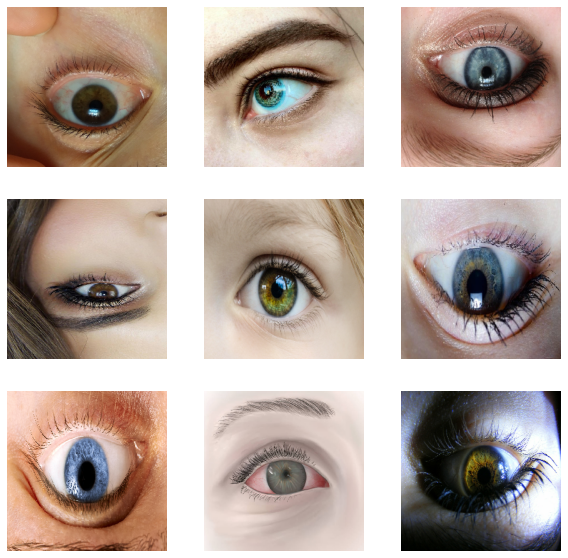

In [18]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(Train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[1])
    plt.axis("off")

# Создание и компиляция модели на основе BiT 

В модели будет использоваться технология BigTransfer, которая позволяет вместо обучения с нуля подстроить уже готовый ИИ, что позволит увеличить качество распознования при прежнем количестве данных

Выберем модель для BigTransfer(BiT) 

In [32]:
bit_model_path = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_path)

Для удобства компиляции воспользуемся классом

In [33]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [34]:
learning_rate = 0.003 / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


Скомпилируем модель

In [35]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [36]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="accuracy", patience=2, restore_best_weights=True
    )
]

# Обучение модели

Внесем в модель данные

In [37]:
history = model.fit(
    traingen,
    epochs=1,
    steps_per_epoch=7,
    callbacks=train_callbacks
)

7/7 [==============================] - 17s 986ms/step - loss: 0.6900 - accuracy: 0.5600


Итоговая точность модели 56%, что ожидаемо с учетом малого количества данных, но демонстрирует жизнеспособность подобной технологии